In [29]:
import pandas as pd
from datetime import datetime
from functools import reduce
import os
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from datetime import datetime, timedelta
import numpy as np
from matplotlib.lines import Line2D
import mplfinance as mpf
import seaborn as sns

# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [11]:
cwd = os.getcwd()  # get current working directory

# Get the parent directory of the current working directory
grandparent_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))

end_date = '2024-04-01'
end_date = datetime.strptime(end_date, '%Y-%m-%d')  # Convert end_date to datetime object
new_date = end_date - timedelta(days=1)  # Subtract 1 day from end_date

new_date_str = new_date.strftime('%Y-%m-%d')  # Convert new_date back to string format

# Load environment variables from .env file
load_dotenv()

# Import environment variables
start_date = os.getenv('start_date')
end_date = os.getenv('end_date')

## Master Data Table - Without Sentiment Data

In [14]:
df_final = pd.read_parquet(os.path.join(grandparent_dir, "data\\processed\\files\\processed_data.parquet.gzip"))

df_final.rename(columns={'value': 'btc_fear_and_greed_index'}, inplace=True)

columns_to_delete = ['BTC_VOLUME', 'value_classification', 'Adj_Close']

# Delete the specified columns
df_final = df_final.drop(columns=columns_to_delete)

# Convert column names to uppercase
df_final.columns = df_final.columns.str.upper()

df_final.columns = df_final.columns.str.replace(' ', '_')

In [16]:
# print(df_final.columns.tolist())

## EDA

### Y variable - Targets

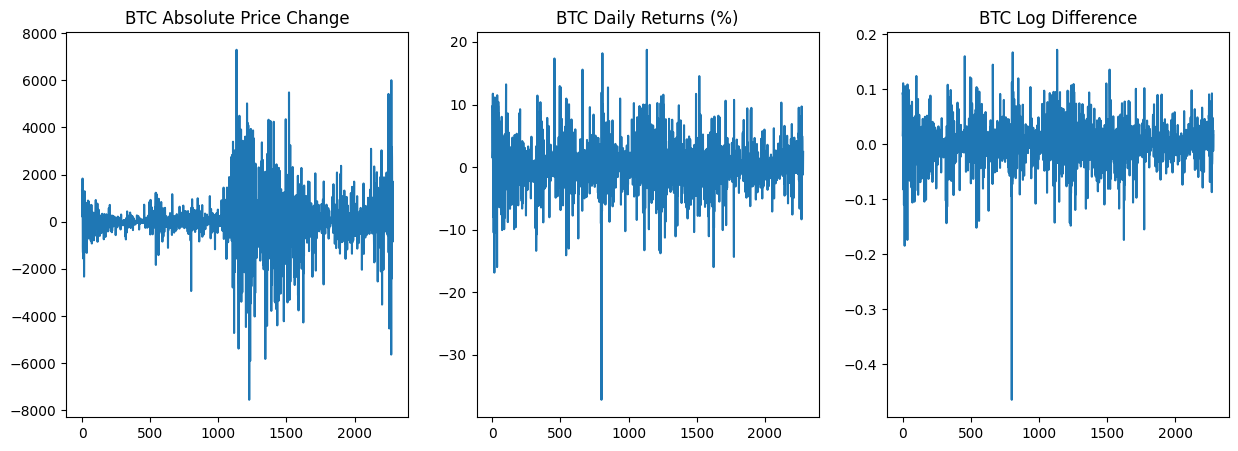

In [17]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot(df_final.BTC_DAILY_ABSOLUTE_CHANGE)
ax[0].set_title('BTC Absolute Price Change')
ax[1].plot(df_final.BTC_DAILY_RETURNS_PERC)
ax[1].set_title('BTC Daily Returns (%)')
ax[2].plot(df_final.BTC_LOG_DIFFERENCE)
ax[2].set_title('BTC Log Difference')
plt.show()

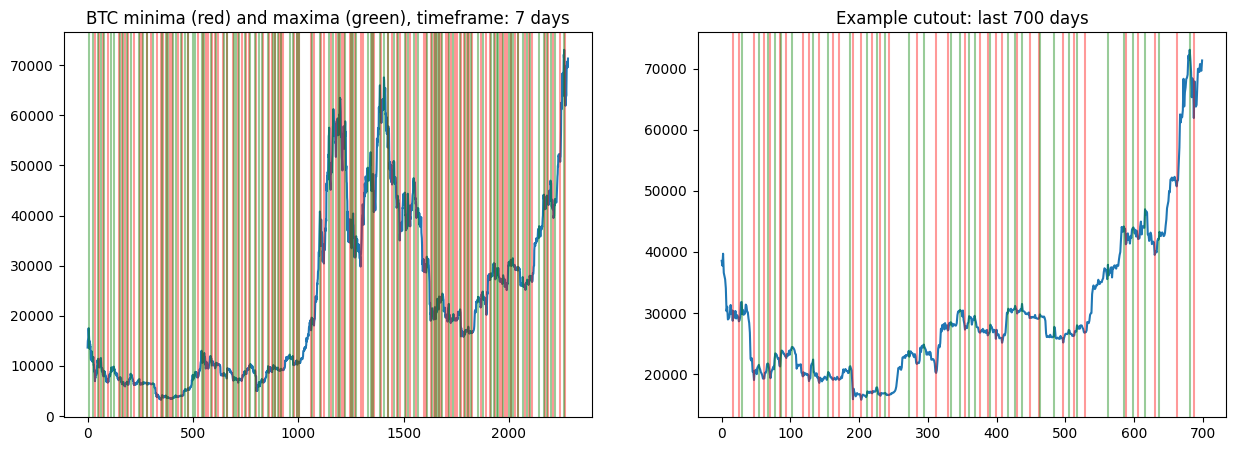

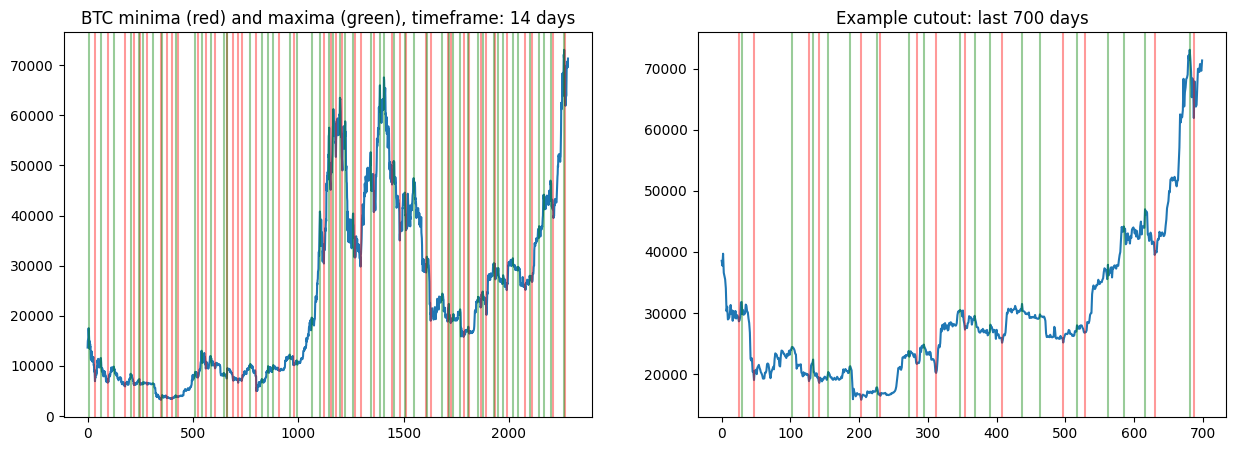

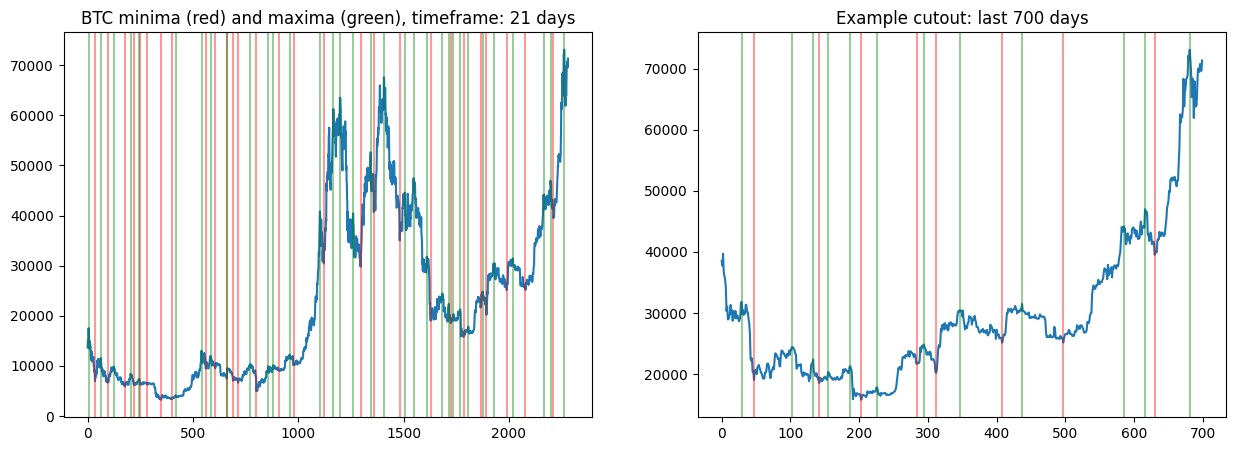

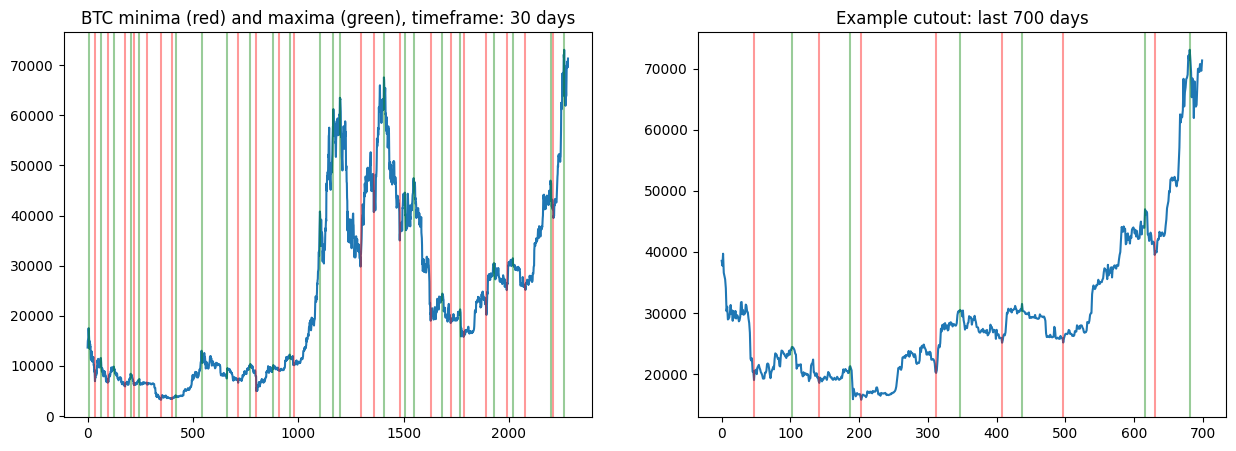

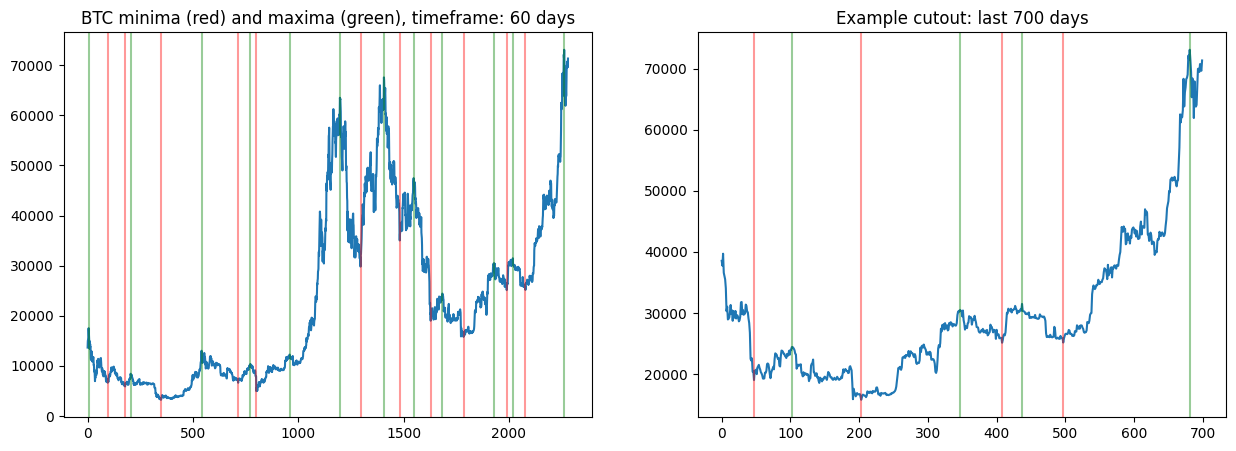

In [18]:
for tf in (7, 14, 21, 30, 60):
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    
    ax[0].plot(df_final.ADJ_CLOSE.reset_index(drop=True))
    for ix in np.nonzero(np.array(df_final[f'BTC_PRICE_MIN_{tf}D']))[0]:
        ax[0].axvline(ix, color='r', alpha=.4)
    for ix in np.nonzero(np.array(df_final[f'BTC_PRICE_MAX_{tf}D']))[0]:
        ax[0].axvline(ix, color='g', alpha=.4)
    ax[0].set_title(f'BTC minima (red) and maxima (green), timeframe: {tf} days')
    
    tail = 700
    
    ax[1].plot(df_final.ADJ_CLOSE.tail(tail).reset_index(drop=True))
    for ix in np.nonzero(np.array(df_final[f'BTC_PRICE_MIN_{tf}D'].tail(tail)))[0]:
        ax[1].axvline(ix, color='r', alpha=.4)
    for ix in np.nonzero(np.array(df_final[f'BTC_PRICE_MAX_{tf}D'].tail(tail)))[0]:
        ax[1].axvline(ix, color='g', alpha=.4)
    ax[1].set_title(f'Example cutout: last {tail} days')
    
    plt.show()

### Revisit

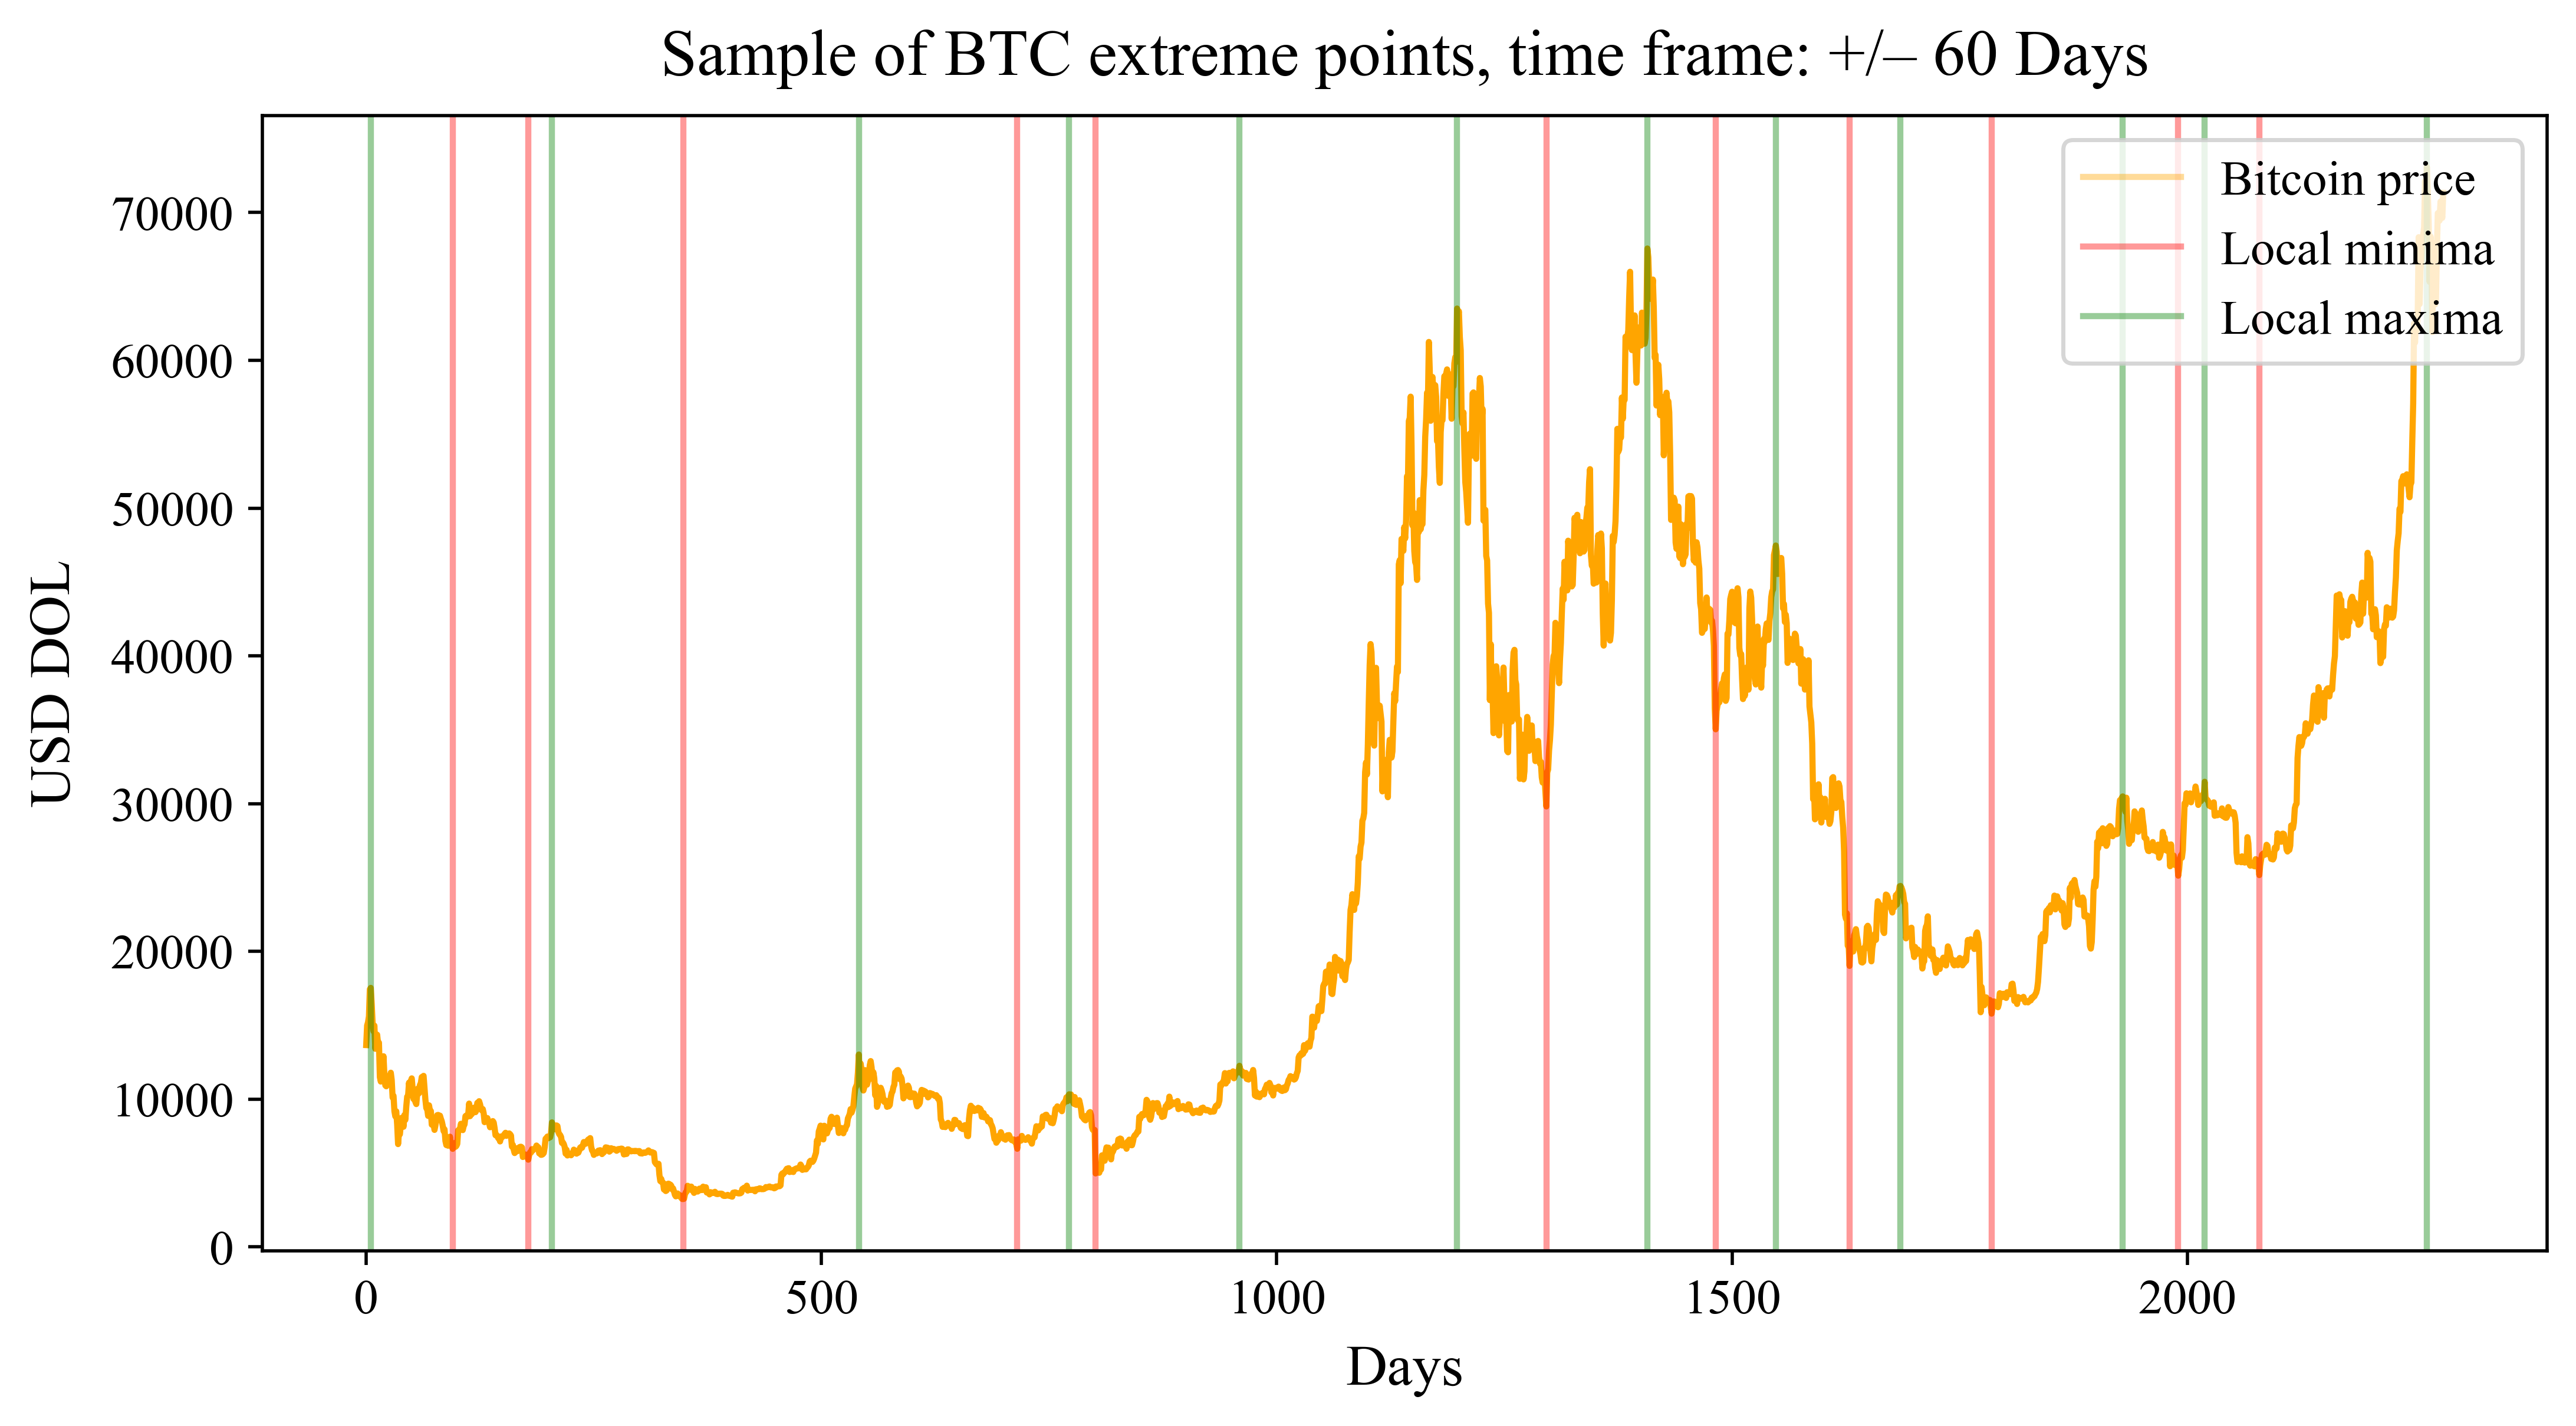

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Set font properties
plt.rcParams['figure.dpi'] = 700
plt.rcParams['font.family'] = 'Times New Roman'
plt.rc('legend', fontsize=12)
plt.rc('axes', labelsize=14)
plt.rc('axes', titlesize=16)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# Define time frame
tf = 60

# Set up the plot
_, ax = plt.subplots(figsize=(10, 5), dpi=500)

# Plot Bitcoin price
ax.plot(np.arange(len(df_final)), df_final.ADJ_CLOSE.reset_index(drop=True), label='Bitcoin price', color='orange')

# Plot local minima
minima_indices = np.nonzero(np.array(df_final[f'BTC_PRICE_MIN_{tf}D']))[0]
for ix in minima_indices:
    ax.axvline(ix, color='red', alpha=.4)

# Plot local maxima
maxima_indices = np.nonzero(np.array(df_final[f'BTC_PRICE_MAX_{tf}D']))[0]
for ix in maxima_indices:
    ax.axvline(ix, color='green', alpha=.4)

# Set title and labels
ax.set_title(f'Sample of BTC extreme points, time frame: +/– {tf} Days', pad=10)
ax.set_xlabel('Days', labelpad=5)
ax.set_ylabel('USD DOL', labelpad=7)

# Add legend
handles, labels = ax.get_legend_handles_labels()
labels = labels + ['Local minima', 'Local maxima']
unique_labels = list(set(labels))

# Define custom legend handles and labels
custom_handles = [
    Line2D([0], [0], color='orange', alpha=.4),
    Line2D([0], [0], color='red', alpha=.4),
    Line2D([0], [0], color='green', alpha=.4)
]
custom_labels = ['Bitcoin price', 'Local minima', 'Local maxima']

# Add custom legend
ax.legend(custom_handles, custom_labels, loc='upper right')

plt.show()


## X Variables - EDA

In [21]:
df_final.head()

,DATE,OPEN,HIGH,LOW,CLOSE,ADJ_CLOSE,VOLUME,GOLD_ADJ_CLOSE,SILVER_ADJ_CLOSE,OIL_ADJ_CLOSE,GOLD_VOLUME,SILVER_VOLUME,OIL_VOLUME,EUR_USD_ADJ_CLOSE,USD_JPY_ADJ_CLOSE,GBP_USD_ADJ_CLOSE,USD_CNY_ADJ_CLOSE,VIX_ADJ_CLOSE,CBOE_INTEREST_RATE_ADJ_CLOSE,TREASURY_YIELD_5YRS_ADJ_CLOSE,RUSSEL_2000_ADJ_CLOSE,ISHARES_20YR_ADJ_CLOSE,TREASURY_BILL_13WK_ADJ_CLOSE,RUSSEL_2000_VOLUME,ISHARES_20YR_VOLUME,TESLA_ADJ_CLOSE,AMD_ADJ_CLOSE,INTEL_ADJ_CLOSE,APPLE_ADJ_CLOSE,NVIDIA_ADJ_CLOSE,META_ADJ_CLOSE,GOOGLE_ADJ_CLOSE,TESLA_VOLUME,AMD_VOLUME,INTEL_VOLUME,APPLE_VOLUME,NVIDIA_VOLUME,META_VOLUME,GOOGLE_VOLUME,GBTC_ADJ_CLOSE,ARKB_ADJ_CLOSE,BITB_ADJ_CLOSE,FBTC_ADJ_CLOSE,BTCO_ADJ_CLOSE,IBIT_ADJ_CLOSE,HODL_ADJ_CLOSE,BITO_ADJ_CLOSE,GBTC_VOLUME,ARKB_VOLUME,BITB_VOLUME,FBTC_VOLUME,BTCO_VOLUME,IBIT_VOLUME,HODL_VOLUME,BITO_VOLUME,ETH_ADJ_CLOSE,ETH_VOLUME,USDT_ADJ_CLOSE,USDT_VOLUME,USDC_ADJ_CLOSE,USDC_VOLUME,DOGE_ADJ_CLOSE,DOGE_VOLUME,XRP_ADJ_CLOSE,XRP_VOLUME,SOL_ADJ_CLOSE,SOL_VOLUME,GAS_ADJ_CLOSE,GAS_VOLUME,GAS_USD,BTC_FEAR_AND_GREED_INDEX,EXTREME_FEAR,EXTREME_GREED,FEAR,GREED,NEUTRAL,SP500_ADJUSTED,GDP,RGDP,UNRATE,CPI,INTEREST_RATE_ADJUSTED,TREASURE_MATURITY_ADJUSTED,INFLATION_RATE_ADJUSTED,STICKY_CPI,M2_MONEY_STOCK_ADJUSTED,VOLUME_ADI,VOLUME_OBV,VOLUME_CMF,VOLUME_FI,VOLUME_EM,VOLUME_SMA_EM,VOLUME_VPT,VOLUME_VWAP,VOLUME_MFI,VOLUME_NVI,VOLATILITY_BBM,VOLATILITY_BBH,VOLATILITY_BBL,VOLATILITY_BBW,VOLATILITY_BBP,VOLATILITY_BBHI,VOLATILITY_BBLI,VOLATILITY_KCC,VOLATILITY_KCH,VOLATILITY_KCL,VOLATILITY_KCW,VOLATILITY_KCP,VOLATILITY_KCHI,VOLATILITY_KCLI,VOLATILITY_DCL,VOLATILITY_DCH,VOLATILITY_DCM,VOLATILITY_DCW,VOLATILITY_DCP,VOLATILITY_ATR,VOLATILITY_UI,TREND_MACD,TREND_MACD_SIGNAL,TREND_MACD_DIFF,TREND_SMA_FAST,TREND_SMA_SLOW,TREND_EMA_FAST,TREND_EMA_SLOW,TREND_VORTEX_IND_POS,TREND_VORTEX_IND_NEG,TREND_VORTEX_IND_DIFF,TREND_TRIX,TREND_MASS_INDEX,TREND_DPO,TREND_KST,TREND_KST_SIG,TREND_KST_DIFF,TREND_ICHIMOKU_CONV,TREND_ICHIMOKU_BASE,TREND_ICHIMOKU_A,TREND_ICHIMOKU_B,TREND_STC,TREND_ADX,TREND_ADX_POS,TREND_ADX_NEG,TREND_CCI,TREND_VISUAL_ICHIMOKU_A,TREND_VISUAL_ICHIMOKU_B,TREND_AROON_UP,TREND_AROON_DOWN,TREND_AROON_IND,TREND_PSAR_UP,TREND_PSAR_DOWN,TREND_PSAR_UP_INDICATOR,TREND_PSAR_DOWN_INDICATOR,MOMENTUM_RSI,MOMENTUM_STOCH_RSI,MOMENTUM_STOCH_RSI_K,MOMENTUM_STOCH_RSI_D,MOMENTUM_TSI,MOMENTUM_UO,MOMENTUM_STOCH,MOMENTUM_STOCH_SIGNAL,MOMENTUM_WR,MOMENTUM_AO,MOMENTUM_ROC,MOMENTUM_PPO,MOMENTUM_PPO_SIGNAL,MOMENTUM_PPO_HIST,MOMENTUM_PVO,MOMENTUM_PVO_SIGNAL,MOMENTUM_PVO_HIST,MOMENTUM_KAMA,OTHERS_DR,OTHERS_DLR,OTHERS_CR,UNIQUE_USERS,FOLLOWERS,TWEET_COUNT,BTC_PERCENTAGE_DOMINANCE,ETH_PERCENTAGE_DOMINANCE,USDT_PERCENTAGE_DOMINANCE,BNB_PERCENTAGE_DOMINANCE,SOL_PERCENTAGE_DOMINANCE,OTHERS_PERCENTAGE_DOMINANCE,GPR,GPRT,GPRA,GPRH,GPRHT,GPRHA,SHARE_GPR,N10,SHARE_GPRH,N3H,GPRH_NOEW,GPR_NOEW,GPRH_AND,GPR_AND,GPRH_BASIC,GPR_BASIC,SHAREH_CAT_1,SHAREH_CAT_2,SHAREH_CAT_3,SHAREH_CAT_4,SHAREH_CAT_5,SHAREH_CAT_6,SHAREH_CAT_7,SHAREH_CAT_8,GPRC_ARG,GPRC_AUS,GPRC_BEL,GPRC_BRA,GPRC_CAN,GPRC_CHE,GPRC_CHL,GPRC_CHN,GPRC_COL,GPRC_DEU,GPRC_DNK,GPRC_EGY,GPRC_ESP,GPRC_FIN,GPRC_FRA,GPRC_GBR,GPRC_HKG,GPRC_HUN,GPRC_IDN,GPRC_IND,GPRC_ISR,GPRC_ITA,GPRC_JPN,GPRC_KOR,GPRC_MEX,GPRC_MYS,GPRC_NLD,GPRC_NOR,GPRC_PER,GPRC_PHL,GPRC_POL,GPRC_PRT,GPRC_RUS,GPRC_SAU,GPRC_SWE,GPRC_THA,GPRC_TUN,GPRC_TUR,GPRC_TWN,GPRC_UKR,GPRC_USA,GPRC_VEN,GPRC_VNM,GPRC_ZAF,GPRHC_ARG,GPRHC_AUS,GPRHC_BEL,GPRHC_BRA,GPRHC_CAN,GPRHC_CHE,GPRHC_CHL,GPRHC_CHN,GPRHC_COL,GPRHC_DEU,GPRHC_DNK,GPRHC_EGY,GPRHC_ESP,GPRHC_FIN,GPRHC_FRA,GPRHC_GBR,GPRHC_HKG,GPRHC_HUN,GPRHC_IDN,GPRHC_IND,GPRHC_ISR,GPRHC_ITA,GPRHC_JPN,GPRHC_KOR,GPRHC_MEX,GPRHC_MYS,GPRHC_NLD,GPRHC_NOR,GPRHC_PER,GPRHC_PHL,GPRHC_POL,GPRHC_PRT,GPRHC_RUS,GPRHC_SAU,GPRHC_SWE,GPRHC_THA,GPRHC_TUN,GPRHC_TUR,GPRHC_TWN,GPRHC_UKR,GPRHC_USA,GPRHC_VEN,GPRHC_VNM,GPRHC_ZAF,MARKET_CAP,CRYPTO_VOLUME_24,WTUI,WUI,BTC_DAILY_ABSOLUTE_CHANGE,BTC_DAILY_RETURNS_PERC,BTC_LOG_DIFFERENCE,BTC_PRICE_MIN_7D,BTC_PRICE_MAX_7D,BTC_PRICE_MIN_14D,BTC_PRICE_MAX_14D,BTC_PRICE_MIN_21D,BTC_PRICE_MAX_21D,BTC_PRICE_MIN_30D,BTC_PRICE_MAX_30

### BTC - ETH

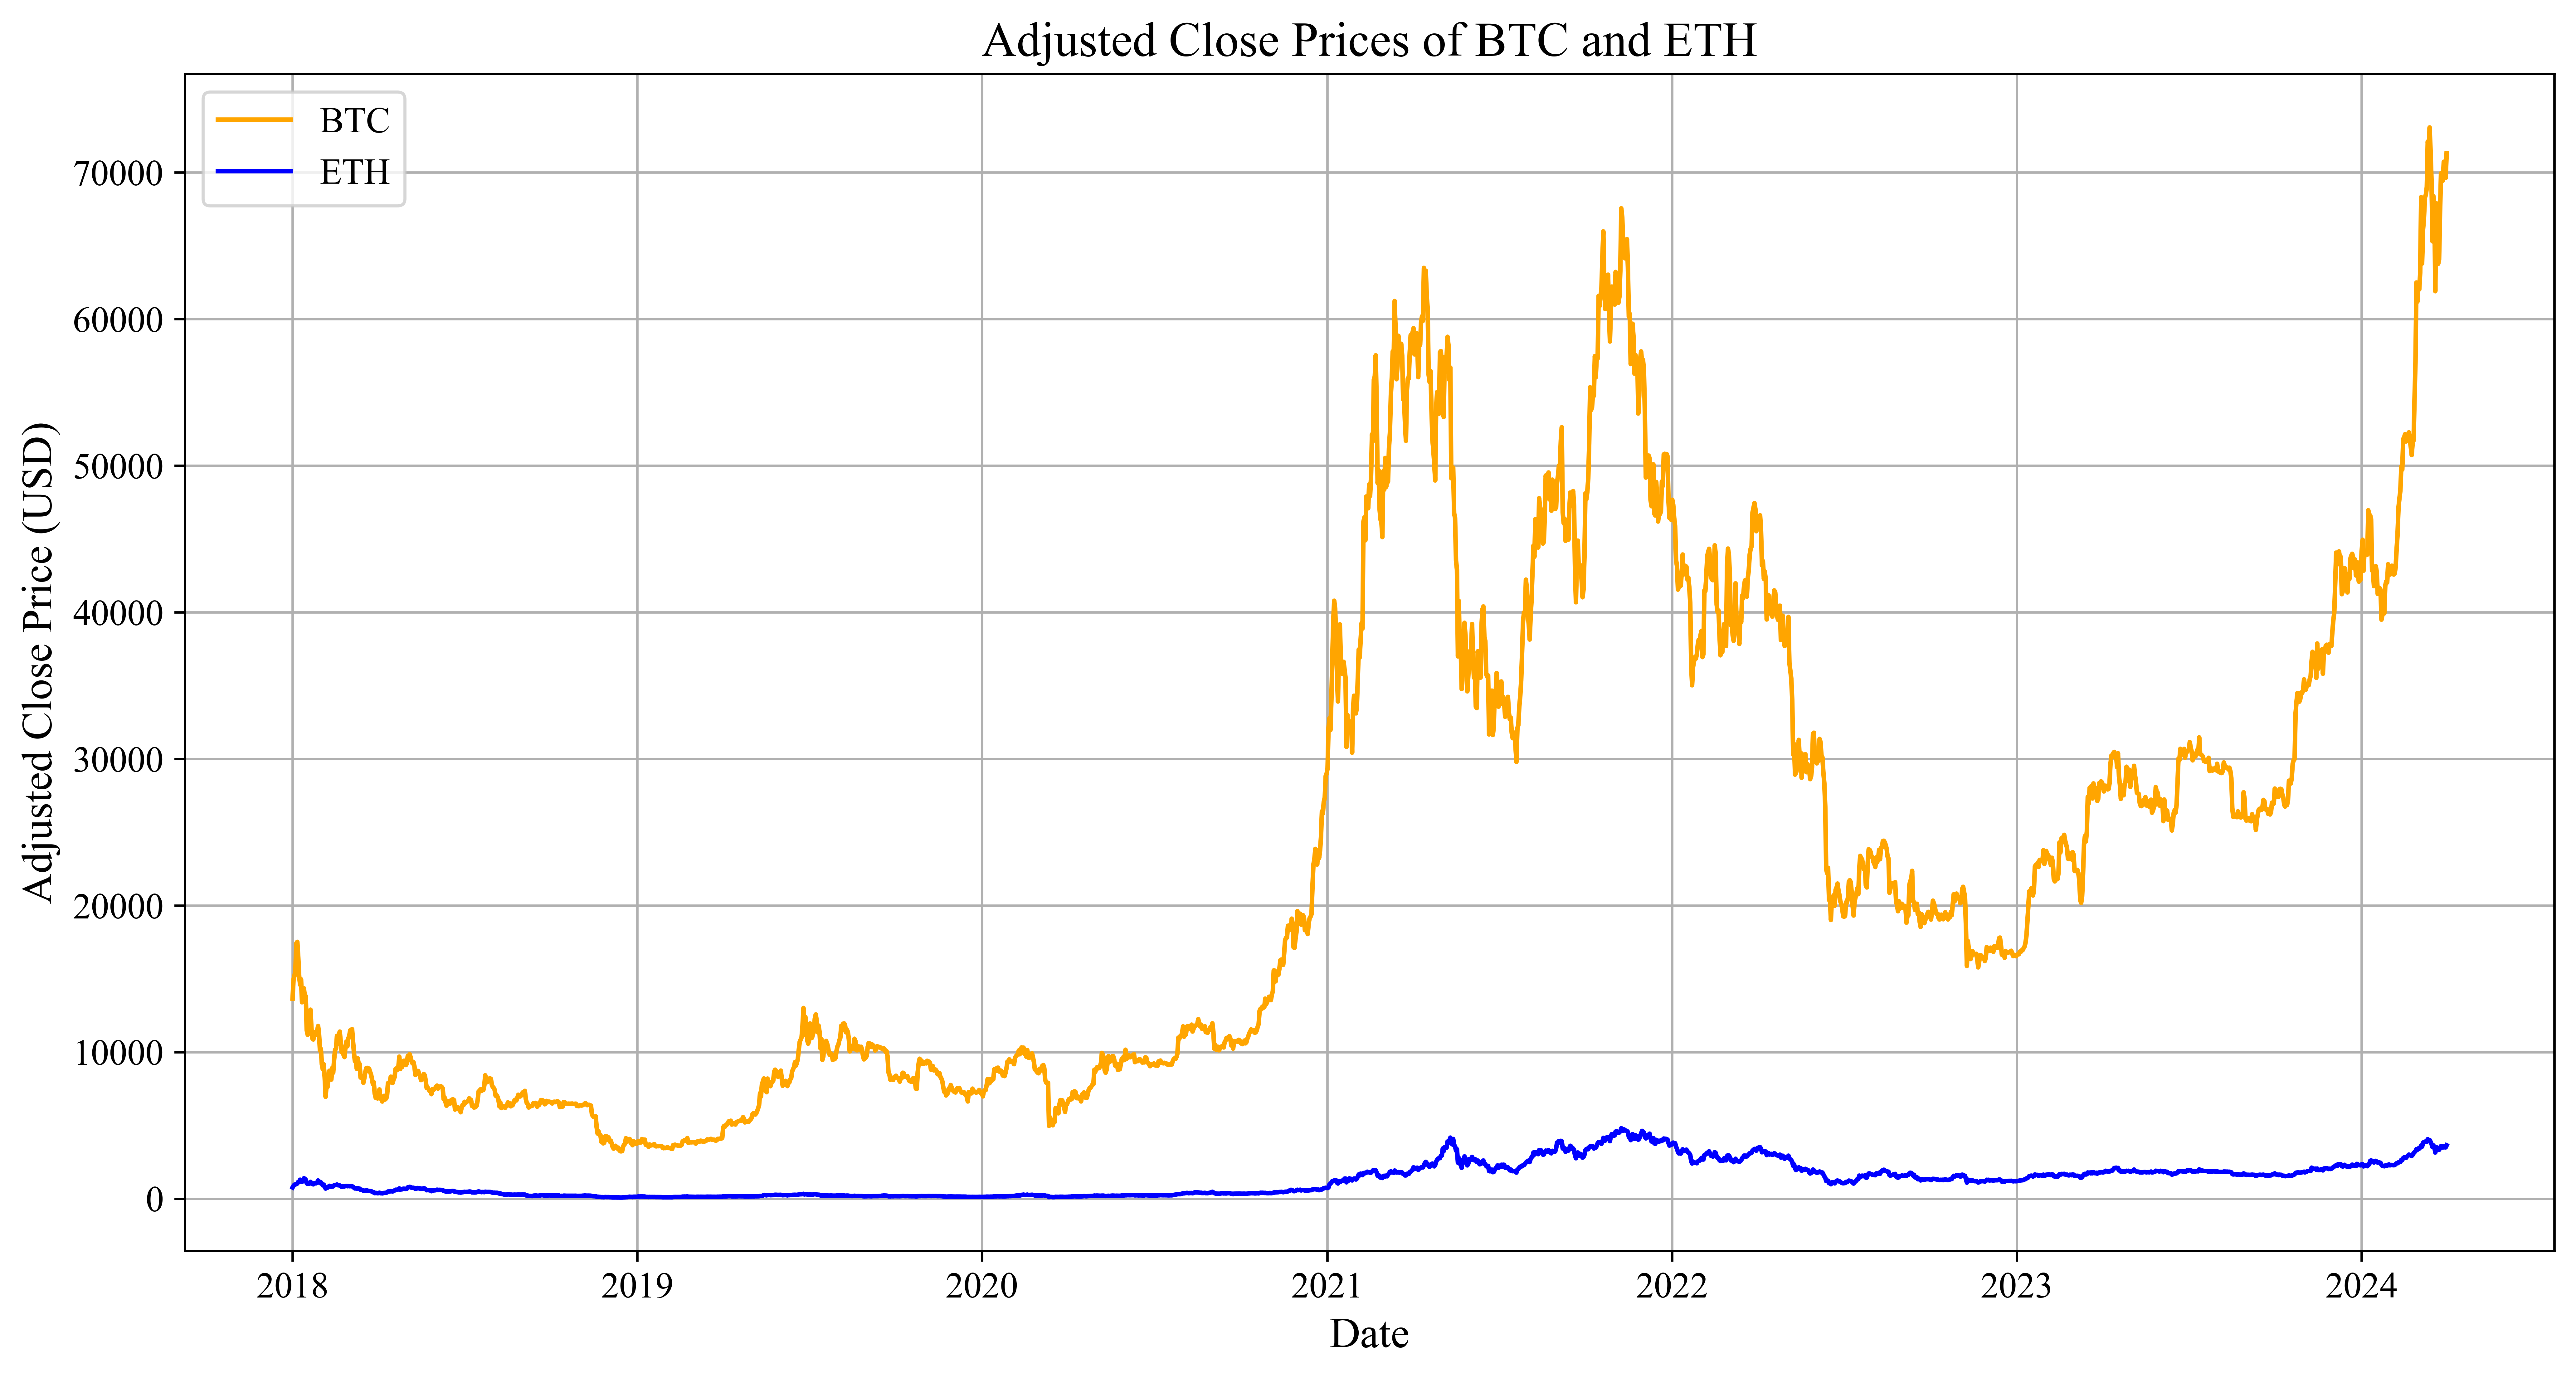

In [22]:
# Convert 'Date' column to datetime type
df_final['DATE'] = pd.to_datetime(df_final['DATE'])

# Plotting the adjusted close prices of BTC and ETH
plt.figure(figsize=(14, 7))
plt.plot(df_final['DATE'], df_final['ADJ_CLOSE'], label='BTC', color='orange')
plt.plot(df_final['DATE'], df_final['ETH_ADJ_CLOSE'], label='ETH', color='blue')
plt.title('Adjusted Close Prices of BTC and ETH')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


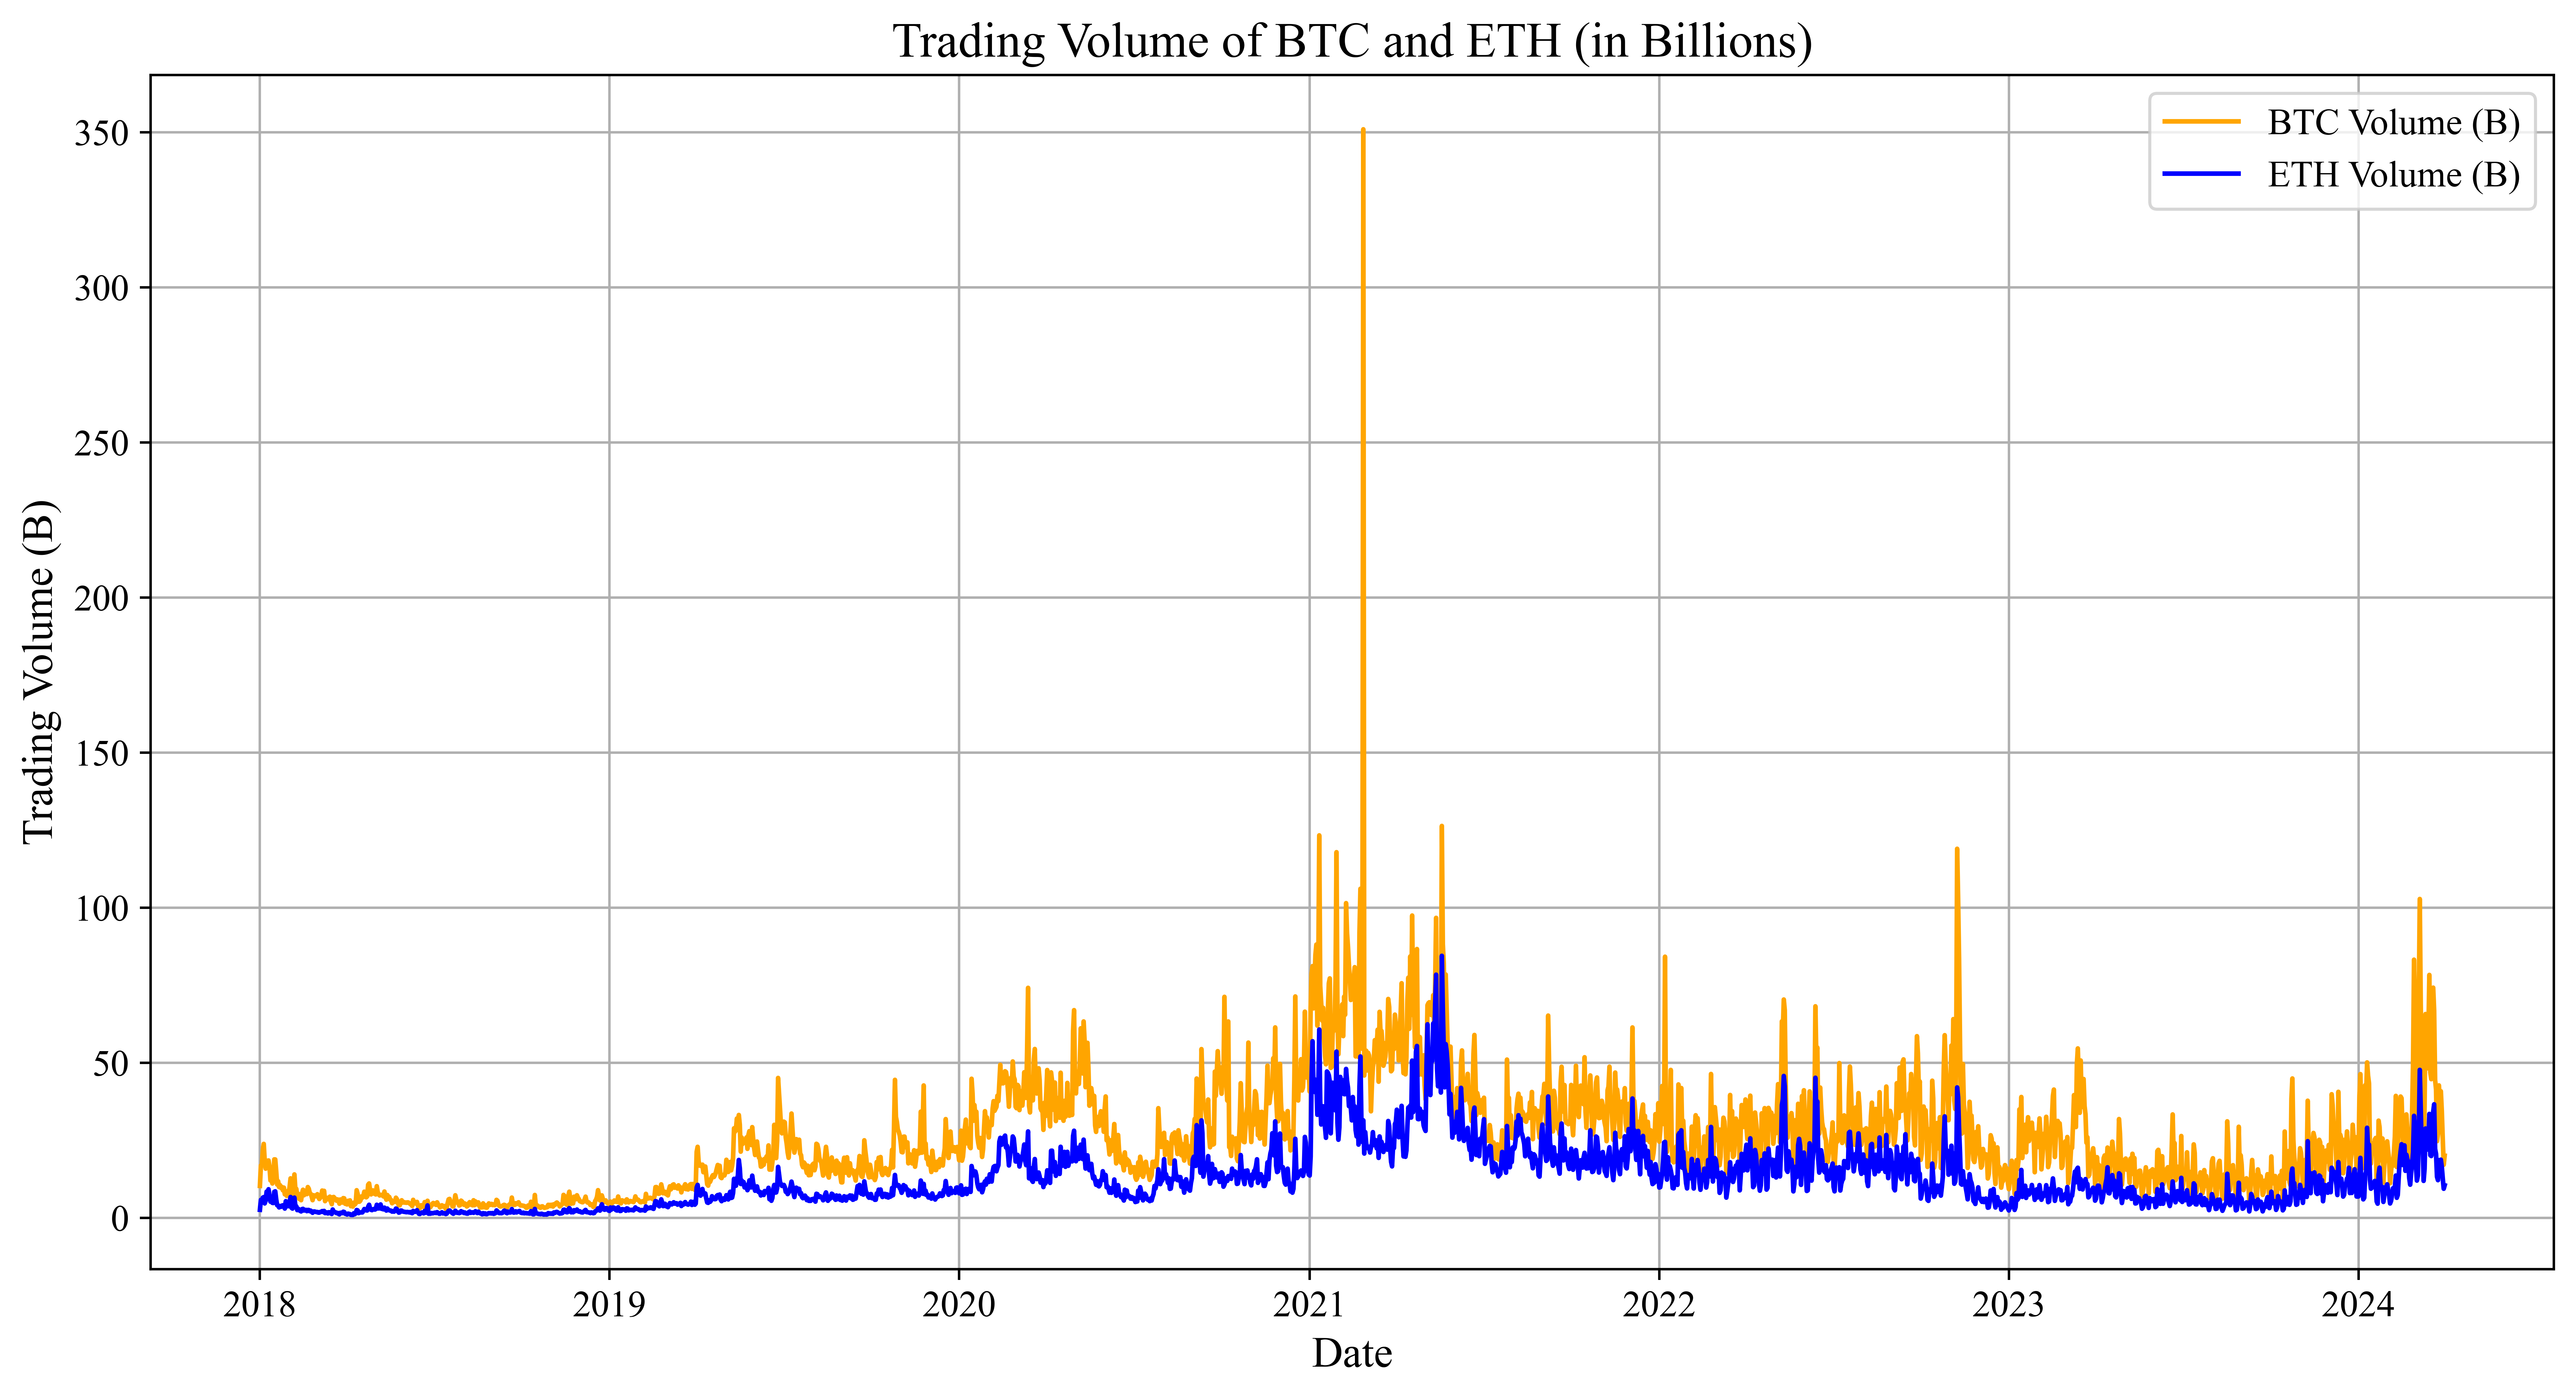

In [25]:
# Convert volumes from absolute numbers to billions for readability
df_final['BTC_VOLUME_B'] = df_final['VOLUME'] / 1e9  # Convert to billions
df_final['ETH_VOLUME_B'] = df_final['ETH_VOLUME'] / 1e9  # Convert to billions

# Plotting the trading volume for BTC and ETH with the converted scale
plt.figure(figsize=(14, 7))
plt.plot(df_final['DATE'], df_final['BTC_VOLUME_B'], label='BTC Volume (B)', color='orange')
plt.plot(df_final['DATE'], df_final['ETH_VOLUME_B'], label='ETH Volume (B)', color='blue')
plt.title('Trading Volume of BTC and ETH (in Billions)')
plt.xlabel('Date')
plt.ylabel('Trading Volume (B)')
plt.legend()
plt.grid(True)
plt.show()


#### BTC Candlestick

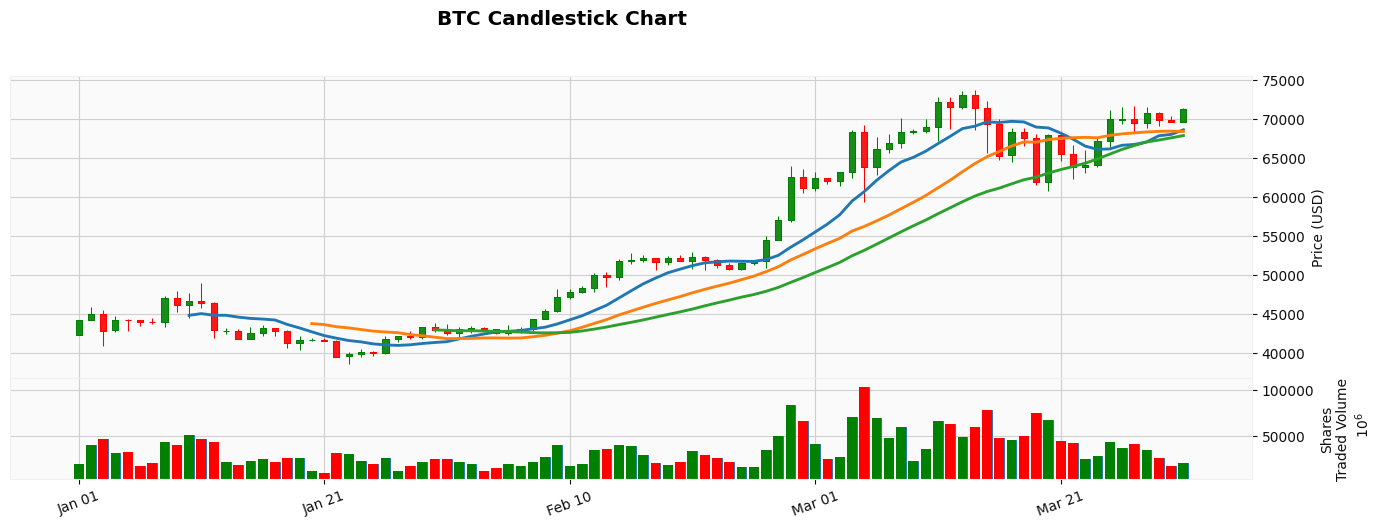

In [28]:
# Assuming btc_eth_data is already defined and contains the necessary data.
btc_data = df_final[['DATE', 'OPEN', 'HIGH', 'LOW', 'ADJ_CLOSE', 'VOLUME']].copy()
btc_data = btc_data[btc_data['DATE'] >= '2024-01-01']

btc_data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
btc_data['Date'] = pd.to_datetime(btc_data['Date'])
btc_data.set_index('Date', inplace=True)

# Define the moving averages
moving_averages = [10, 20, 30]

# Create a dictionary to hold the moving average data
mpf_sma = dict()
for ma in moving_averages:
    mpf_sma[ma] = btc_data['Close'].rolling(window=ma).mean()

# Define the style for up and down days
mc = mpf.make_marketcolors(
    up='green', down='red',
    edge='inherit',
    wick='inherit',
    volume='inherit',
    ohlc='inherit'
)

s = mpf.make_mpf_style(
    base_mpf_style='yahoo',
    marketcolors=mc
)

# Customize the plot to include volume in green or red
colors = []
for index, row in btc_data.iterrows():
    if row['Close'] > row['Open']:
        colors.append('green')
    else:
        colors.append('red')

volume_plt = mpf.make_addplot(btc_data['Volume'], type='bar', panel=1, color=colors)

# Adding moving averages to the plot
add_plots = [volume_plt]
for ma in moving_averages:
    add_plots.append(mpf.make_addplot(mpf_sma[ma]))

# Plotting the chart with the new style and title font
mpf.plot(
    btc_data,
    type='candle',
    style=s,
    addplot=add_plots,
    volume=True,
    title='BTC Candlestick Chart',
    ylabel='Price (USD)',
    ylabel_lower='Shares\nTraded Volume',
    figratio=(12, 4),
    panel_ratios=(3, 1),  # ratio between main chart and lower volume chart
    scale_width_adjustment=dict(volume=0.8, candle=1.0),  # adjust the widths of candles and volume bars
    xrotation=20,  # rotate dates for better readability
    datetime_format='%b %d',  # format for dates on the x-axis
    show_nontrading=False  # whether to show non-trading days
)


#### BTC - ETH Correlation

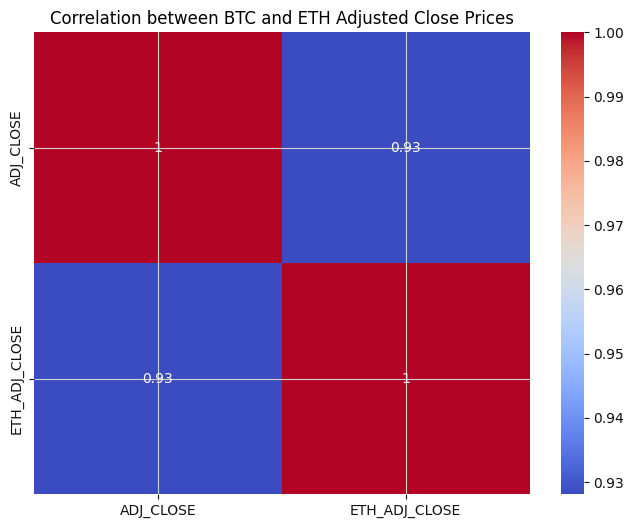

In [30]:
# Calculating the correlation matrix for the adjusted close prices of BTC and ETH
corr_data = df_final[['ADJ_CLOSE', 'ETH_ADJ_CLOSE']].corr()

# Plotting the heatmap for correlation
plt.figure(figsize=(8, 6))
sns.heatmap(corr_data, annot=True, cmap='coolwarm')
plt.title('Correlation between BTC and ETH Adjusted Close Prices')
plt.show()